In [39]:
from pyspark.sql import SparkSession
import pandas as pd
import wetstatsoncorpus
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('wetstatsoncorpus_notebook').getOrCreate()

In [3]:
df = spark.read.parquet("for_stats")

In [4]:
df.show(10)

+--------------------+-------------------+-------+----------+----+
|                 url|             domain|country|      date|lang|
+--------------------+-------------------+-------+----------+----+
|https://bb.linuxs...|bb.linuxsampler.org|     US|2020-03-28|  en|
|https://bb.mail.r...|         bb.mail.ru|     RU|2020-03-28|  ru|
|https://bb.mail.r...|         bb.mail.ru|     RU|2020-03-28|  ru|
|https://bb.visita...|  bb.visitaruba.com|     US|2020-03-28|  en|
|https://bbbmovie....|       bbbmovie.com|     US|2020-03-28|  fr|
|https://bbcvietna...|  bbcvietnamnet.com|     SG|2020-03-28|  vi|
|https://bbqmaster...|  bbqmastershop.com|     US|2020-03-28|  en|
|https://bbs.archl...|  bbs.archlinux.org|     IN|2020-03-28|  en|
|https://bbs.archl...|  bbs.archlinux.org|     IN|2020-03-28|  en|
|https://bbs.csdn....|       bbs.csdn.net|     CN|2020-03-28|  zh|
+--------------------+-------------------+-------+----------+----+
only showing top 10 rows



In [5]:
df_stats_lang = wetstatsoncorpus.stats(df, "lang", pct=True)
pd_stats_lang = df_stats_lang.limit(20).toPandas()
pd_stats_lang.head()

,lang,count,pct
0,en,83898,39.798111
1,zh,17495,8.298982
2,ru,15163,7.192767
3,de,12927,6.132091
4,fr,10442,4.953299


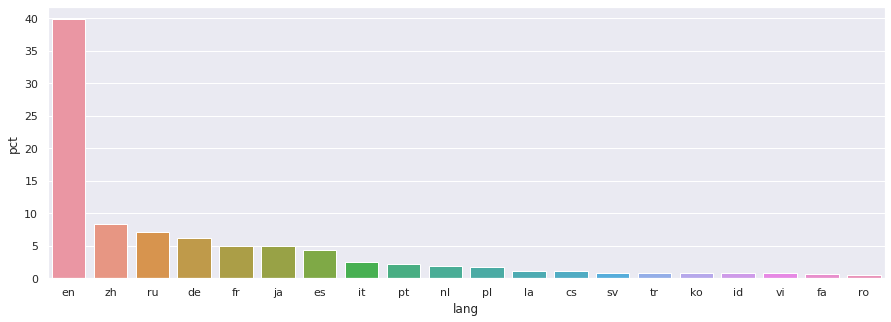

In [18]:
plt.figure(figsize=(15, 5))
sns.barplot(x = 'lang', y = 'pct', data = pd_stats_lang);

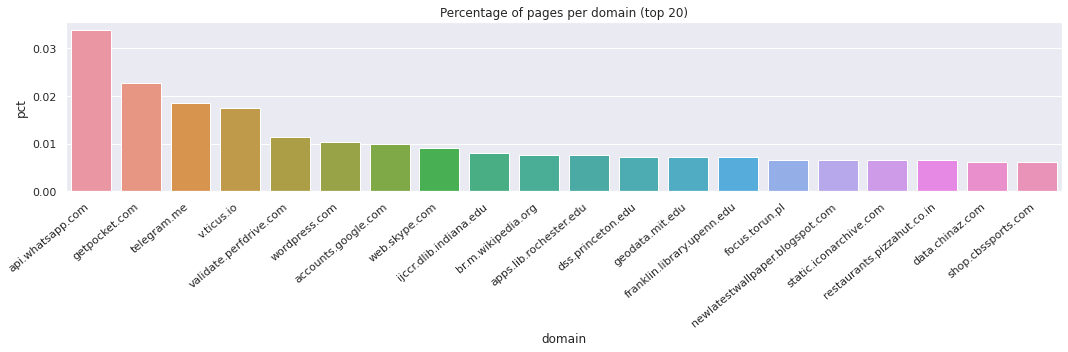

In [26]:
df_stats_domain = wetstatsoncorpus.stats(df, "domain", pct=True)
pd_stats_domain = df_stats_domain.limit(20).toPandas()
plt.figure(figsize=(15, 5))
sns.barplot(x = 'domain', y = 'pct', 
                 data = pd_stats_domain).set_title('Percentage of pages per domain (top 20)');
plt.xticks(rotation=40, ha='right')
plt.tight_layout()

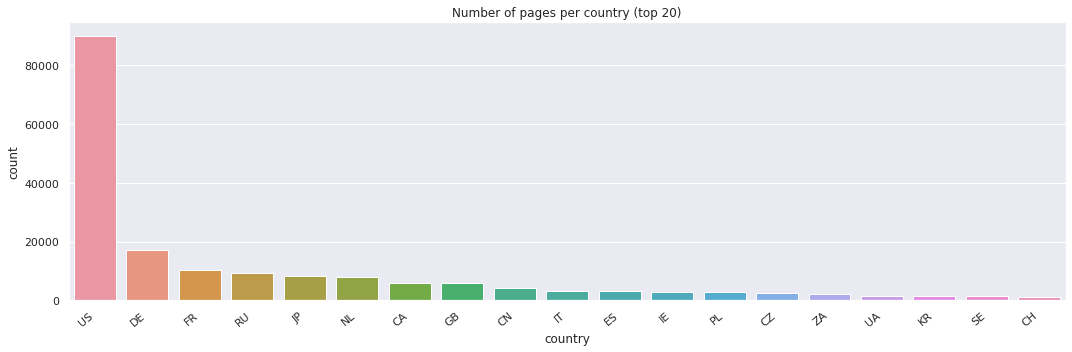

In [31]:
df_stats_country = wetstatsoncorpus.stats(df, "country", pct=True)
pd_stats_country = df_stats_country.limit(20).toPandas()

plt.figure(figsize=(15, 5))
sns.barplot(x = 'country', y = 'count', 
            data = pd_stats_country).set_title('Number of pages per country (top 20)');
plt.xticks(rotation=40, ha='right')
plt.tight_layout()

In [32]:
main_countries = list(pd_stats_country.dropna()['country'].head(12).values)
main_countries

['US', 'DE', 'FR', 'RU', 'JP', 'NL', 'CA', 'GB', 'CN', 'IT', 'ES', 'IE']

In [33]:
main_langs = list(pd_stats_lang.dropna()['lang'].head(12).values)
main_langs

['en', 'zh', 'ru', 'de', 'fr', 'ja', 'es', 'it', 'pt', 'nl', 'pl', 'la']

In [46]:
hmdf = wetstatsoncorpus.stats_2_fields(df, "country", "lang")
hmdf = hmdf.filter((hmdf.country.isin(main_countries)) & (hmdf.lang.isin(main_langs)))
print(hmdf.select("country").distinct().count())
print(hmdf.select("lang").distinct().count())
pd_hmdf = hmdf.toPandas().pivot(index='lang', columns='country', values='count').fillna(1).astype('int32')

12
12


In [47]:
pd_hmdf

country,CA,CN,DE,ES,FR,GB,IE,IT,JP,NL,RU,US
lang,,,,,,,,,,,,
de,40,2,8577,34,192,72,380,37,3,282,22,1755
en,4613,104,2887,274,2178,4613,1166,369,183,2325,250,56693
es,187,4,617,2199,565,135,167,72,4,278,17,3966
fr,461,1,499,48,5585,82,204,55,10,332,17,2228
it,26,2,372,12,339,101,148,2577,4,163,17,1394
ja,19,6,30,2,28,19,139,16,7688,118,4,1992
la,53,27,154,37,96,46,41,30,80,142,54,1183
nl,29,1,212,2,92,38,146,2,1,2258,4,777
pl,9,1,220,1,282,23,15,14,1,76,10,508


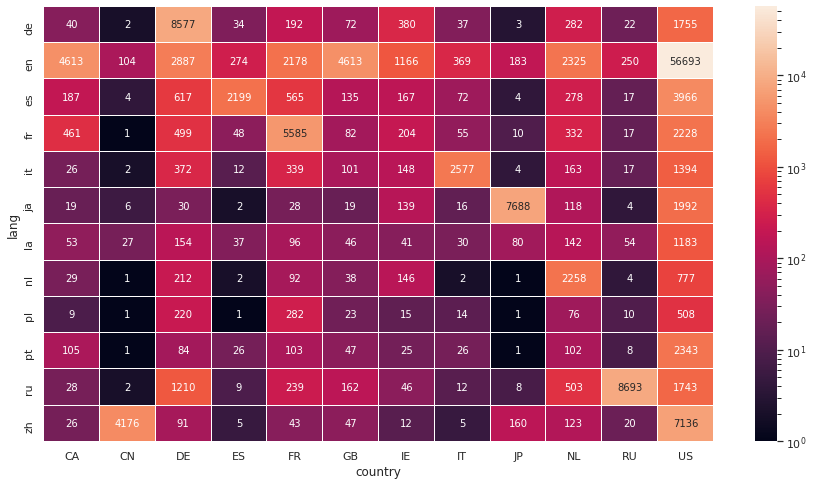

In [50]:
f = plt.figure(figsize=(15, 8))
# print(df.dtypes)
sns.heatmap(pd_hmdf, annot=True, linewidth=0.1, norm=LogNorm(), fmt='g');
# plt.setp(f.axes[0].xaxis.get_majorticklabels(), rotation=35, ha='right');

In [21]:
spark.stop()